# Predicting Credit Card Default

### Data Set Information:

**This research aimed at the case of customers default payments in Taiwan**

### Features description:

- LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- SEX: Gender (1 = male; 2 = female). 
- EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- MARRIAGE: Marital status (1 = married; 2 = single; 3 = others). 
- AGE: Age (year). 
- PAY_0 - PAY_6: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 0 = the repayment status in September, 2005; 1 = the repayment status in August, 2005; . . .; 6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- BILL_AMT1-BILL_AMT6: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- PAY_AMT1-PAY_AMT6: Amount of previous payment (NT dollar).
- default payment next month: **positive class: default | negative class: pay**

In [2]:
# Importing useful libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 0. Data Preparation

In [4]:
default = pd.read_csv('./data/credit_card_default.csv', index_col="ID")
# Cange column names to lower case
default.columns = default.columns.str.lower()
# For pay features if the <= 0 then it means it was not delayed. Set all negativ values to 0
pay_features = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
for p in pay_features:
    default.loc[default[p]<=0, p] = 0
# Rename target to shorter name
default.rename(columns={'default payment next month':'default'}, inplace=True) 

In [5]:
# Create dummy variables
# Base values: female, other_education, not_married
# == return True or False and astype('int') coverts to 1 for True and 0 for False
default['grad_school'] = (default['education'] == 1).astype('int')
default['university'] = (default['education'] == 2).astype('int')
default['high_school'] = (default['education'] == 3).astype('int')
default['male'] = (default['sex']==1).astype('int')
default['married'] = (default['marriage'] == 1).astype('int')
# Remove columns
default.drop(['education', 'sex', 'marriage'] , axis=1, inplace=True)

# Building models using all features

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import RobustScaler

In [7]:
# Check if data is imbalanced
default['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [8]:
# Create training and test sets
target_name = 'default'
X = default.drop('default', axis=1)
robust_scaler = RobustScaler()
X = robust_scaler.fit_transform(X)
y = default[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [9]:
# Function creating a nice confusion matrix
def CMatrix(CM, labels=['pay','default']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name='TRUE'
    df.columns.name='PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

### Preparing a DataFrame for model analysis

In [10]:
# Data frame for evaluation metrics
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall'], 
                      columns=['NULL','LogisticReg', 'ClassTree', 'NaiveBayes'])

### Error metrics
- **Accuracy**: the proportion of the total number of predictions that are correct, (TP+TN)/Total​
- **Precision**: the proportion of positive predictions that are actually correct, TP/(TP+FP)​ 
- **Recall**: the proportion of positive observed values correctly predicted as such, TP/(TP+FN) 

**In this application:**
- **Accuracy**: Overall how often the model predicts correctly defaulters and non-defaulters
- **Precision**: When the model predicts **default**: how often is correct?
- **Recall**: The proportion of **actual defaulters** that the model will correctly predict as such

#### Which metric should I use?

- **False Positive**: A person who will pay predicted as defaulter
- **False Negative**: A person who will default predicted as payer

#### False negatives are worse => look for a better recall

## The Null model: always predict the most common category

In [11]:
# Count occurance of each category and idxmax() is selecting the most occured being 0
y_pred_test = np.repeat(y_train.value_counts().idxmax(), y_test.size)
metrics.loc['accuracy','NULL'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NULL'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NULL'] = recall_score(y_pred=y_pred_test, y_true=y_test)

CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,4673,0,4673
default,1327,0,1327
Total,6000,0,6000


## A. Logistic Regression

In [13]:
# 1. Import the estimator object (model)
from sklearn.linear_model import LogisticRegression

# 2. Create an instance of the estimator
logistic_regression = LogisticRegression(n_jobs=-1, random_state=15)

# 3. Use the trainning data to train the estimator
logistic_regression.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = logistic_regression.predict(X_test)
metrics.loc['accuracy','LogisticReg'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','LogisticReg'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','LogisticReg'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,4480,193,4673
default,894,433,1327
Total,5374,626,6000


## B. Classification Trees

In [15]:
# 1. Import the estimator object (model)
from sklearn.tree import DecisionTreeClassifier

# 2. Create an instance of the estimator
class_tree = DecisionTreeClassifier(min_samples_split=30, min_samples_leaf=10, random_state=10)

# 3. Use the trainning data to train the estimator
class_tree.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = class_tree.predict(X_test)
metrics.loc['accuracy','ClassTree'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','ClassTree'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','ClassTree'] = recall_score(y_pred=y_pred_test, y_true=y_test)
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,4226,447,4673
default,827,500,1327
Total,5053,947,6000


## C. Naive Bayes Classifier

In [16]:
# 1. Import the estimator object (model)
from sklearn.naive_bayes import GaussianNB

# 2. Create an instance of the estimator
NBC = GaussianNB()

# 3. Use the training data to train the estimator
NBC.fit(X_train, y_train)

# 4. Evaluate the model
y_pred_test = NBC.predict(X_test)
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_test, y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_test, y_true=y_test)

#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
CMatrix(CM)

PREDICTION,pay,default,Total
TRUE,,,
pay,3877,796,4673
default,585,742,1327
Total,4462,1538,6000


In [17]:
# 100*metrics to get percentage 
100*metrics

,NULL,LogisticReg,ClassTree,NaiveBayes
accuracy,77.8833,81.8833,78.7667,76.9833
precision,0,69.1693,52.7983,48.2445
recall,0,32.63,37.679,55.9156


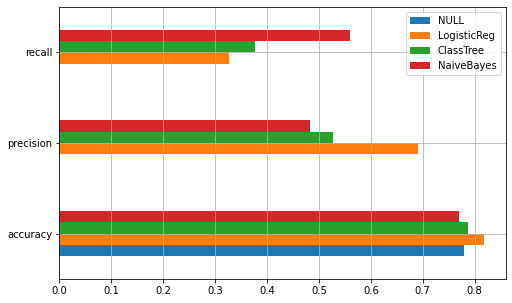

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(kind='barh', ax=ax)
ax.grid();

### Threshold
- Classification algorithms classify to postitive (1) och negative (0) class by using probability and e threshold value 
- Threshold is the least probability classifying an observation to the postive class
- Default is 0.5 (50%)
- Threshold can be tuned to improve precision and recall
- Scikit-learn compute precision-recall pairs for different probability thresholds to find optimal threshold

In [19]:
NBC.predict_proba(X_test)

array([[6.47920766e-03, 9.93520792e-01],
       [9.70875459e-01, 2.91245412e-02],
       [9.12959130e-12, 1.00000000e+00],
       ...,
       [9.40609852e-01, 5.93901478e-02],
       [1.82698758e-01, 8.17301242e-01],
       [9.43442355e-01, 5.65576449e-02]])

In [20]:
# Threshold
# predict_proba returns array (n_samples, n_classes), use [:,1] to get positive class default 
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test, 
                                            probas_pred=NBC.predict_proba(X_test)[:,1])
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, 
                                            probas_pred=logistic_regression.predict_proba(X_test)[:,1])

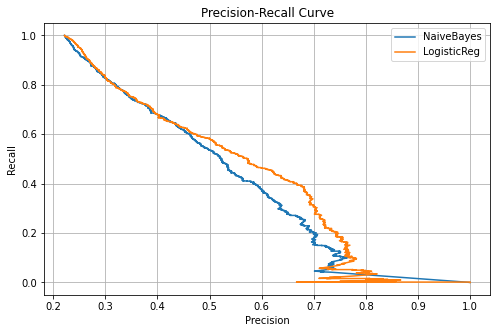

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(precision_nb, recall_nb, label='NaiveBayes')
ax.plot(precision_lr, recall_lr, label='LogisticReg')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
#ax.hlines(y=0.5, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

### Confusion matrix for modified Logistic Regression Classifier

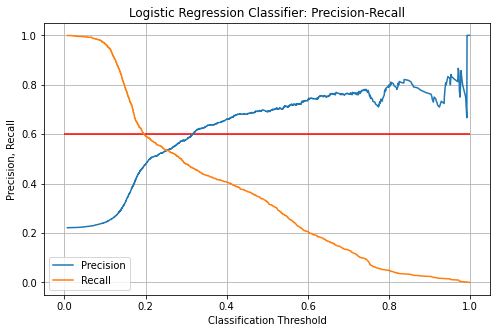

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(thresholds_lr, precision_lr[1:], label='Precision')
ax.plot(thresholds_lr, recall_lr[1:], label='Recall')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Precision, Recall')
ax.set_title('Logistic Regression Classifier: Precision-Recall')
ax.hlines(y=0.6, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

### Classifier with threshold of 0.2

In [23]:
y_pred_proba = logistic_regression.predict_proba(X_test)[:,1]
y_pred_test = (y_pred_proba >= 0.2).astype('int')
#Confusion matrix
CM = confusion_matrix(y_pred=y_pred_test, y_true=y_test)
print("Recall: ", 100*recall_score(y_pred=y_pred_test, y_true=y_test))
print("Precision: ", 100*precision_score(y_pred=y_pred_test, y_true=y_test))
CMatrix(CM)

Recall:  59.23134890730972
Precision:  47.75212636695018


PREDICTION,pay,default,Total
TRUE,,,
pay,3813,860,4673
default,541,786,1327
Total,4354,1646,6000


### Making individual predictions

In [61]:
def make_ind_prediction(new_data):
    data = new_data.values.reshape(1, -1)
    data = robust_scaler.transform(data)
    prob = logistic_regression.predict_proba(data)[0][1]
    if prob >= 0.2:
        return 'Will default'
    else:
        return 'Will pay'

In [62]:
from collections import OrderedDict
new_customer = OrderedDict([('limit_bal', 4000),('age', 50 ),('bill_amt1', 500),
                            ('bill_amt2', 35509 ),('bill_amt3', 689 ),('bill_amt4', 0 ),
                            ('bill_amt5', 0 ),('bill_amt6', 0 ), ('pay_amt1', 0 ),('pay_amt2', 35509 ),
                            ('pay_amt3', 0 ),('pay_amt4', 0 ),('pay_amt5', 0 ), ('pay_amt6', 0 ),
                            ('male', 1 ),('grad_school', 0 ),('university', 1 ), ('high_school', 0 ),
                            ('married', 1 ),('pay_0', -1 ),('pay_2', -1 ),('pay_3', -1 ),
                            ('pay_4', 0),('pay_5', -1), ('pay_6', 0)])

new_customer = pd.Series(new_customer)
make_ind_prediction(new_customer)

'Will default'